In [1]:
from ipynb.fs.full.extracao import fetch_pokedex, damage_matrix, Types
import pandas as pd
from enum import Enum
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn
import matplotlib.pyplot as plt
from imageio.v2 import imread
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

# Capturando dados

In [2]:
class BattleRole(Enum):
    Attacker = "Attacker"
    SPAttacker = "SPAttacker"
    Tank = "Tank"
    SPTank = "SPTank"
    Sweeper = "Sweeper"  ## Rapida velocidade e ataque

In [3]:
status_columns = ["base_hp", "base_attack", "base_defense", "base_special_attack", "base_special_defense", "base_speed"]
pokedex_df = fetch_pokedex()

In [4]:
pokedex_df["status_mean"] = pokedex_df[status_columns].mean(axis=1)
pokedex_df = pd.concat([pokedex_df, pd.DataFrame(pokedex_df["type"].to_list(), columns=['type1', 'type2'])], axis=1)

# Removendo dados indesejados

## Média dos status

<Axes: >

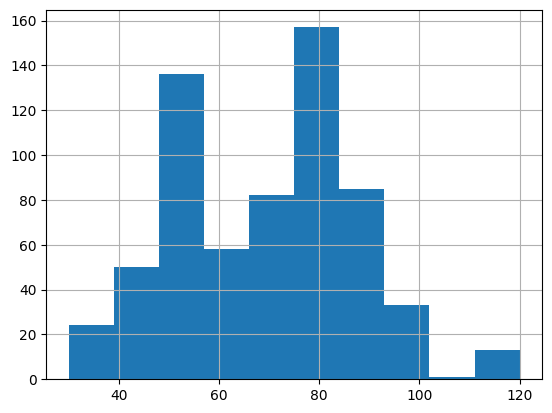

In [5]:
pokedex_df["status_mean"].hist()

Calculando percentis

<Axes: >

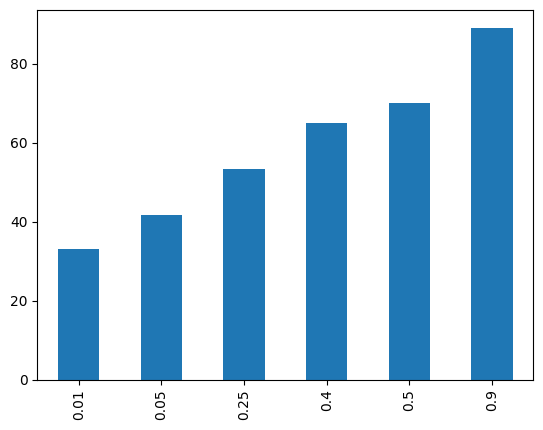

In [6]:
pokedex_df["status_mean"].quantile([.01, 0.05, 0.25, .4, 0.5, .9]).plot.bar()

In [7]:
valor_mediana = pokedex_df["status_mean"].quantile(0.3)

Aqui vou tirar somente 70% dos pokemons com a maior media dos status, para evitar que pokemons fracos sejam colocados nas predições.  
Também vou checar a distribuição de tipo e shape depois.

In [8]:
pokedex_df_filtered = pokedex_df[pokedex_df["status_mean"] >= valor_mediana]

Checando a distribuição de tipos

## TODO: salvar o pokedex_df_filtered num arquivo

Text(0, 0.5, 'Quantidade')

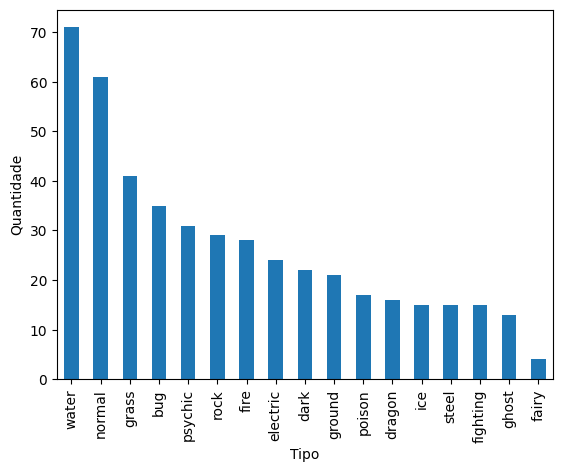

In [9]:
pokedex_df_filtered['type1'].value_counts().plot(kind='bar')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')

Comparando com a distribuição original, podemos ver que não mudou muito.

Text(0, 0.5, 'Quantidade')

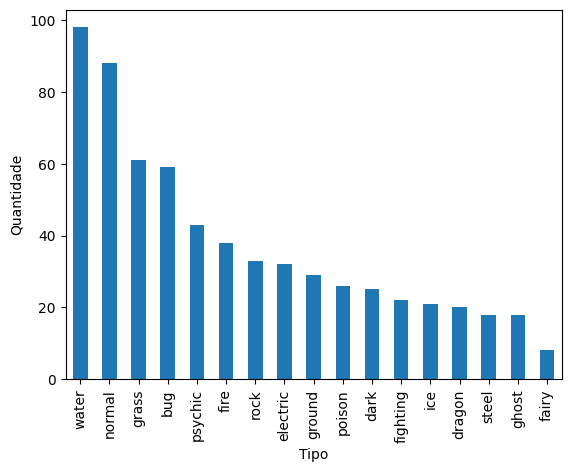

In [10]:
pokedex_df['type1'].value_counts().plot(kind='bar')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')

## Dados de treinamento

In [11]:
pokemon_by_role = {
    "SPAttacker": ["camerupt", "charizard", "rayquaza", "ampharos", "gardevoir", "slowbro", "tangrowth", "manaphy",
                   "sceptile", "gengar", "gengar", "alakazam", "mew", "espeon", "mewtwo"],
    ##, "keldeo"
    "Attacker": ["monferno", "gallade", "rampardos", "blaziken", "heracross", "groudon", "crawdaunt", "garchomp",
                 "weavile", "infernape", "lucario", "salamence", "gyarados",
                 "dragonite", "excadrill"],
    "Tank": ["slaking", "tangrowth", "clefable", "tyranitar", "gastrodon", "chansey", "gliscor", "shuckle", "steelix",
             "cloyster", "bastiodon", "snorlax", "quagsire", "wobbuffet", "wailord", "hariyama", "wigglytuff"]
}

Text(0.5, 1.0, 'Distribuição de classes')

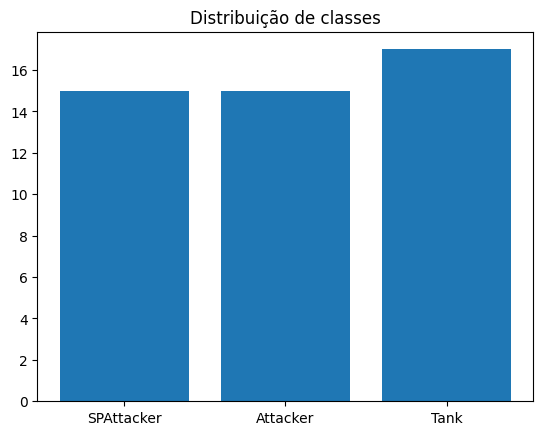

In [12]:
key_cnt = {}
for key in pokemon_by_role:
    key_cnt[key] = len(pokemon_by_role[key])
fig, ax = plt.subplots()
plt.bar(key_cnt.keys(), key_cnt.values())
ax.set_title('Distribuição de classes')


## Treinando modelos

In [13]:
train_data = pd.DataFrame(
    columns=status_columns + ["role"]
)

In [14]:
for key in pokemon_by_role.keys():
    pokemons = pokemon_by_role[key]

    for pokemon in pokemons:
        pokemon_data = pokedex_df_filtered[pokedex_df_filtered["name"] == pokemon]
        row = {
            "role": key
        }
        for status in status_columns:
            try:
                row[status] = pokemon_data[status].values[0]
            except e:
                print(f"Pokemon {pokemon} não foi encontrado")
                raise e
        row_series = pd.Series(row)
        train_data = pd.concat(
            [train_data, row_series.to_frame().T],
            ignore_index=True
        )

In [15]:
## TODO: balancear as classes de treinamento
X_train, X_test, y_train, y_test = train_test_split(train_data[status_columns], train_data["role"], random_state=2)

Testando os modelos SVM, LogisticRegression, RandomForestClassifier e DecisionTreeClassifier


In [16]:
models = [
    ("SVM", svm.SVC()),
    ("LogisticRegression", LogisticRegression(solver='newton-cholesky')),
    ("RandomForestClassifier", RandomForestClassifier(max_depth=4)),
    ("DecisionTreeClassifier", DecisionTreeClassifier(max_depth=4)),
]
scores = []
for (name, model) in models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name} = {score}")
    scores.append(score)

bestModelIdx = scores.index(max(scores))
print(f"Melhor modelo: {models[bestModelIdx][0]}")

SVM = 0.8333333333333334
LogisticRegression = 0.9166666666666666
RandomForestClassifier = 0.75
DecisionTreeClassifier = 0.8333333333333334
Melhor modelo: LogisticRegression


In [17]:
model = models[bestModelIdx][1]

Testando combinações do LogisticRegression

In [18]:
param_grid = {
    'solver': ['newton-cg', 'newton-cg', 'newton-cg', 'newton-cholesky'],
    'tol': [.1, .01, .001, .0002],
    # 'C': [0.1, 0.01, 0.2, 0.5, 0.7, 1]
    # 'penalty': ['l1', 'l2', 'elasticnet', None],
}

pipeline = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=10)
pipeline.fit(X_train, y_train)
print(pipeline.score(X_test, y_test))

1.0


In [19]:
model = pipeline

<Axes: >

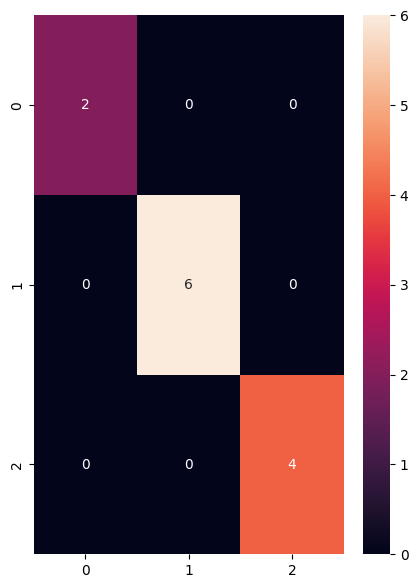

In [20]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 7))
sn.heatmap(conf_matrix, annot=True)

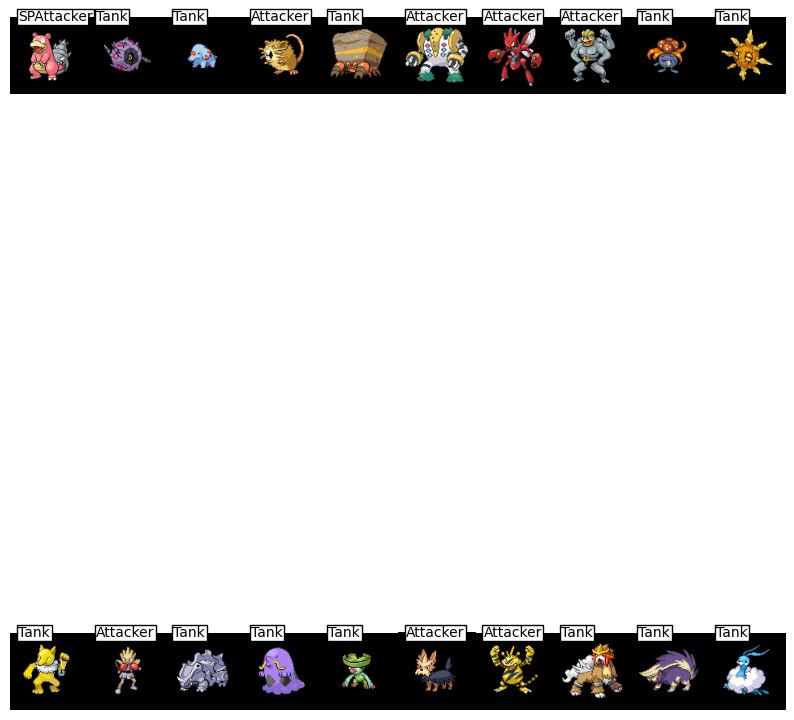

In [21]:
pokedex_df_sample = pokedex_df_filtered.sample(n=20)

pokedex_df_sample = pokedex_df_sample.assign(
    role=pipeline.predict(pokedex_df_sample[status_columns])
).reset_index()

f, axarr = plt.subplots(2, 10, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 3})

for i in range(2):
    for j in range(10):
        image_url = pokedex_df_sample.loc[(i * 10) + j]["image_url"]
        image_file = imread(image_url)
        name = pokedex_df_sample.loc[(i * 10) + j]["name"]
        role = pokedex_df_sample.loc[(i * 10) + j]["role"]
        axarr[i][j].text(10, 5, role, bbox={'facecolor': 'white', 'pad': 1})

        axarr[i][j].imshow(image_file)
        axarr[i][j].axis('off')
        axarr[i][j].set_aspect('equal')

plt.show()